# Определение стоимости автомобилей

На основании исторических данных: технические характеристики, комплектации и цены автомобилей нужно построить модель для определения стоимости автомобиля. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Установка пакетов

In [1]:
import sys

#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install --upgrade Pillow
#!{sys.executable} -m pip install -U ydata-profiling[notebook]
#!jupyter nbextension enable --py widgetsnbextension
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install category_encoders

### Импорт библиотек

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib

import pandas as pd
import lightgbm as lgb
import category_encoders as ce

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

#from ydata_profiling import ProfileReport

In [3]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

### Загрузка и предобработка данных

#### Первичный анализ данных

In [4]:
df = pd.read_csv('autos.csv')

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [9]:
#profile = ProfileReport(df, title="Autos")
#profile.to_widgets()
#profile.to_file("old_cars.html")

#### Дубликаты

Поскольку время публикации объявления указано с точностью до дня, а вряд ли в течение дня будут продаваться абсолютно одинаковые машины, то дубликаты смело удаляем.

In [10]:
df.duplicated().sum()

4

In [11]:
df = df.drop_duplicates().reset_index(drop=True)

#### Пропуски

In [12]:
for c in df.columns:
    if df[c].isna().sum() > 0:
        print(c, '---', df[c].isna().sum(), '--- missed')

VehicleType --- 37490 --- missed
Gearbox --- 19833 --- missed
Model --- 19705 --- missed
FuelType --- 32895 --- missed
Repaired --- 71154 --- missed


Прежде чем заполнять пропуски посмотрим, каких годов машины продаются

In [13]:
df['RegistrationYear'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

**Машины в основном середины 2000-х годов, на основании этого, а также исходя из общих соображений предположу, что дефолтная машина, для которой в датасете есть пропуски - это бензиновая машина с механической КПП, не ремонтировавшаяся. И пропуски заполню так:**

- VehicleType - 'other'
- Gearbox - 'manual'
- model - 'no model'
- FuelType - 'petrol'
- Repaired - 'False'

In [14]:
df['VehicleType'] = df['VehicleType'].fillna('other')
df['Gearbox'] = df['Gearbox'].fillna('manual')
df['Model'] = df['Model'].fillna('no model')
df['FuelType'] = df['FuelType'].fillna('petrol')
df['Repaired'] = df['Repaired'].fillna('no')

#### Неинформативные для обучения модели столбцы

- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

будут удалены

In [15]:
useless_columns = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
df = df.drop(useless_columns, axis=1)

#### Аномалии

Очевидно, что аномальные значения могут быть только в столбцах с количественными признаками

In [16]:
numbers = []
for c in df.columns:
    if df[c].dtypes == 'int64':
        print(c, '\n')
        print(df[c].describe(), '\n')
        numbers.append(c)

Price 

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64 

RegistrationYear 

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64 

Power 

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64 

Kilometer 

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64 



**С аномалиями поступлю следующим образом**

- RegistrationYear - оставлю значения в диапазоне от 1983 до 2016 года (год самого свежего объявления)
- Power - оставлю значения в диапазоне от 41 (smart) до 730 (какой-то суперкар от mercedes-benz)
- Kilometer - не буду трогать. да, значения пробега в 5000 км неправдоподобны, но не невозможны

Что делать с ценой пока непонятно, надо смотреть на нее внимательнее

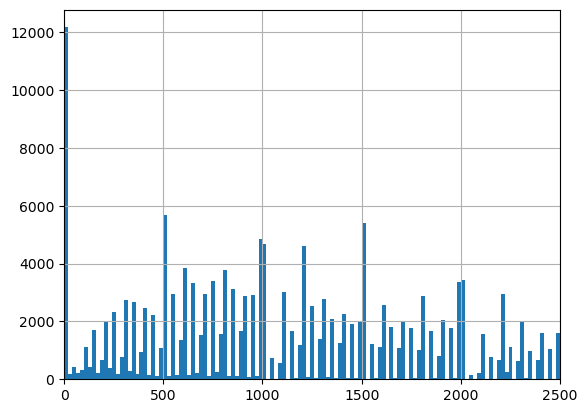

In [18]:
df['Price'].hist(bins=1000)
plt.xlim(0, 2500)
plt.show()

Сильно яснее не стало. Цена = 0 - это явно отбрасывается, а вот что за благотворительный аукцион с тысячами машин, дешевле, чем 1000 евро - пока непонятно. Посмотрим, что именно это за машины

In [19]:
df_grouped = df.groupby('VehicleType').agg({'Price':['median']})
df_grouped

,Price
,median
VehicleType,
bus,4200.0
convertible,5500.0
coupe,3950.0
other,1200.0
sedan,2999.0
small,1500.0
suv,8500.0
wagon,3200.0


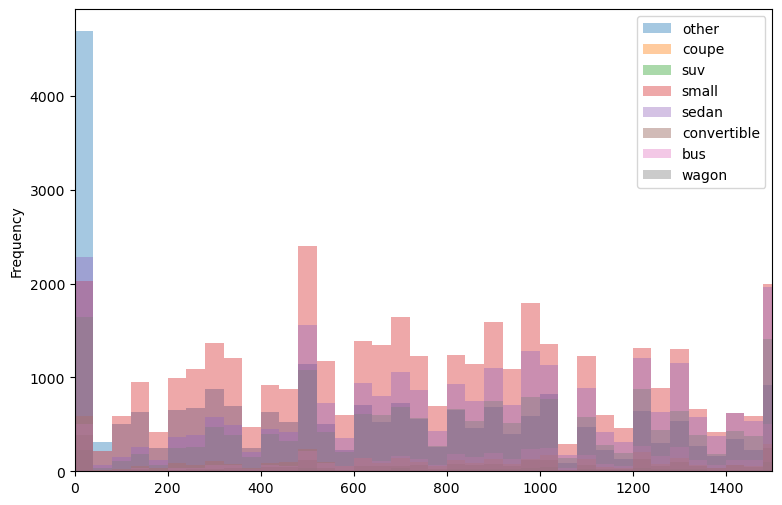

In [20]:
for c in df['VehicleType'].unique():
    data = df.loc[df['VehicleType'] == c]
    data['Price'].plot(figsize=(9,6), kind='hist', bins=500, alpha=.4, label=c, legend=True, xlim=(0,1500))

Кроме аномалии "мусорных объявлений" с неуказанной категорией машины и нулевой ценой пока выделить какой-то аномальный тип машин не получается

In [21]:
df_grouped = df.groupby('Repaired').agg({'Price':['median']})
df_grouped

,Price
,median
Repaired,
no,2999.0
yes,900.0


Вот тут уже более понятно. Объем и тип ремонта не оговорен, критерия "машина на ходу" в датасете нет, так что, предположив, что у нас сервис по продаже машин на ходу, а не доноров запчастей, отбросим строки, где цена меньше 1000 евро. [И вот пример](https://www.autoexpress.co.uk/best-cars/98976/best-cars-for-1000-or-less)

In [22]:
df = df.drop(df[(df['Price'] > df['Price'].quantile(.99)) | (df['Price'] < 1000)].index)
df = df.drop(df[(df['RegistrationYear'] < 1983) | (df['RegistrationYear'] > 2016)].index)
df = df.drop(df[(df['Power'] < 41) | (df['Power'] > 730)].index)

#### Деление данных на выборки

In [23]:
df_train, df_test = train_test_split(df, test_size=.25, random_state=3105)

#### Масштабирование данных

In [24]:
numbers.remove('Price')
scaler = StandardScaler()
scaler.fit(df_train[numbers])
df_train.loc[:,numbers] = scaler.transform(df_train[numbers])
df_test.loc[:,numbers] = scaler.transform(df_test[numbers])

#### Features & Targets

In [25]:
target_train = df_train['Price']
target_test = df_test['Price']
features_train = df_train.drop(['Price'], axis=1)
features_test = df_test.drop(['Price'], axis=1)

#### Вывод

**При первичном анализе данных выявлено:**

- В данных практически нет дубликатов
- В отдельных категориальных признаках есть пропуски (не более 20% значений)
- В данных есть объяснимые положительные корреляции между ценой и годом выпуска машины и ценой и мощностью.

**В ходе подготовки данных выполнено:**

- удаление дубликатов
- заполнение пропусков
- удаление неинформативных столбцов
- удаление аномалий
- деление данных на обучающую и тестовую выборку

## Обучение моделей

### Выбор моделей

**Для исследования выбраны:**

- **CatBoost** (варьируемые параметры - скорость обучения (2 варианта), глубина деревьев (5 вариантов), число деревьев (2 варианта)) Для подбора параметров я специально даю ему только df_train, то что по умолчанию он выбирает 20% выборки как тестовую считаю частью кросс-валидации. На тестовой выборке буду проверять только лучшую из выбранных моделей.
- **Light GMB** проверены 3 значения скорости обучения и 3 значения количества параметров на листе
- **Случайный лес**, для которого будут варьироваться число деревьев, глубина деревьев и число параметров на листе
- **И линейная регрессия** (из общих соображений кажется, что цена машины с пробегом зависит в первую очередь от ~~наглости перекупщика~~ от пробега или возраста, а поэтому простая линейная модель может быть уместна

### CatBoost

In [26]:
model = CatBoostRegressor(cat_features=[0, 2, 4, 6, 7, 8], verbose=False)

grid = {'learning_rate': [0.01, 0.1],
        'depth': range (2,11,2),
        'n_estimators': range (50,150,50)}
start = time.time()
grid_search_result = model.grid_search(grid, X=features_train, y=target_train, cv=3, plot=True, verbose=False)
stop = time.time()   
best_cat = CatBoostRegressor(**grid_search_result['params'], random_state=3105, cat_features=[0, 2, 4, 6, 7, 8], verbose=False)
joblib.dump(best_cat, 'best_cat.joblib')
print(grid_search_result['params'])
print(f'SEARCHING TIME --- {stop - start}s')

C:\Users\MiAir\anaconda3\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 4921.939087
bestIteration = 49


bestTest = 2195.612674
bestIteration = 49


bestTest = 3753.643671
bestIteration = 99


bestTest = 2011.425354
bestIteration = 99


bestTest = 4799.467807
bestIteration = 49


bestTest = 1953.991234
bestIteration = 49


bestTest = 3529.477277
bestIteration = 99


bestTest = 1829.596873
bestIteration = 99


bestTest = 4735.074758
bestIteration = 49


bestTest = 1849.683044
bestIteration = 49


bestTest = 3419.593052
bestIteration = 99


bestTest = 1751.441676
bestIteration = 99


bestTest = 4700.47481
bestIteration = 49


bestTest = 1777.770453
bestIteration = 49


bestTest = 3363.104523
bestIteration = 99


bestTest = 1682.24332
bestIteration = 99


bestTest = 4679.894365
bestIteration = 49


bestTest = 1724.014617
bestIteration = 49


bestTest = 3326.440873
bestIteration = 99


bestTest = 1638.385602
bestIteration = 99

Training on fold [0/3]

bestTest = 1630.977359
bestIteration = 99

Training on fold [1/3]

bestTest = 1624.213633
bestIter

In [27]:
model = joblib.load('best_cat.joblib')
start = time.time()
model.fit(features_train, target_train)
stop = time.time()
print(f'fit time ---{stop - start}s' )
start = time.time()
model.predict(features_train)
stop = time.time()
print(f'predict time ---{stop - start}s' )

fit time ---14.531579494476318s
predict time ---0.9307258129119873s


### LightGBM

In [28]:
categ = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
labelencoder = LabelEncoder()
l_features_train = features_train.copy()
for c in categ:
    l_features_train[c] = labelencoder.fit_transform(l_features_train[c])
for c in categ:
    l_features_train[c] = l_features_train[c].astype('int')

In [29]:
train_data = lgb.Dataset(l_features_train, label=target_train, feature_name=l_features_train.columns.to_list(), \
                         categorical_feature=categ, free_raw_data=False)
start = time.time()
best_params = {}
best_rmse = 1e6

for leaf in [5, 10, 12]:
    for r in [0.05, 0.1, 0.2]:
        params = {'objective': 'regression', 'force_col_wise': True, 'learning_rate': r, 'num_leaves': leaf}
        cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100,
        nfold=3,
        metrics='rmse',
        return_cvbooster=True
        )
        if min(cv_results['valid rmse-mean']) < best_rmse:
            best_rmse = min(cv_results['valid rmse-mean'])
            best_params = params
stop = time.time()

print('BEST RMSE ---', min(cv_results['valid rmse-mean']))
print(f'SEARCHING TIME --- {stop - start}s')

C:\Users\MiAir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Start training from score 5621.038592
[LightGBM] [Info] Start training from score 5617.356108
[LightGBM] [Info] Start training from score 5617.700393


C:\Users\MiAir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Start training from score 5621.038592
[LightGBM] [Info] Start training from score 5617.356108
[LightGBM] [Info] Start training from score 5617.700393


C:\Users\MiAir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Start training from score 5621.038592
[LightGBM] [Info] Start training from score 5617.356108
[LightGBM] [Info] Start training from score 5617.700393


C:\Users\MiAir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Start training from score 5621.038592
[LightGBM] [Info] Start training from score 5617.356108
[LightGBM] [Info] Start training from score 5617.700393


C:\Users\MiAir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Start training from score 5621.038592
[LightGBM] [Info] Start training from score 5617.356108
[LightGBM] [Info] Start training from score 5617.700393


C:\Users\MiAir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Start training from score 5621.038592
[LightGBM] [Info] Start training from score 5617.356108
[LightGBM] [Info] Start training from score 5617.700393


C:\Users\MiAir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Start training from score 5621.038592
[LightGBM] [Info] Start training from score 5617.356108
[LightGBM] [Info] Start training from score 5617.700393


C:\Users\MiAir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Start training from score 5621.038592
[LightGBM] [Info] Start training from score 5617.356108
[LightGBM] [Info] Start training from score 5617.700393


C:\Users\MiAir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 117484, number of used features: 9
[LightGBM] [Info] Start training from score 5621.038592
[LightGBM] [Info] Start training from score 5617.356108
[LightGBM] [Info] Start training from score 5617.700393
BEST RMSE --- 1607.4289066343206
SEARCHING TIME --- 33.15071630477905s


In [30]:
start = time.time()
best_lgb = lgb.train(best_params, train_data, num_boost_round=100)
stop = time.time()
print(f'fit time ---{stop - start}s' )
start = time.time()
best_lgb.predict(l_features_train)
stop = time.time()
print(f'predict time ---{stop - start}s' )

[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 176226, number of used features: 9
[LightGBM] [Info] Start training from score 5618.698365
fit time ---0.7600874900817871s
predict time ---0.5799922943115234s


### Случайный лес. 

**Здесь (и для регрессии тоже) сперва придется закодировать категориальные признаки**

One-HOT encoder использовать не хочу, поскольку возможных значений категориальных признаков слишком много, а Label Encoder создаст ненужные взаимозависимости в данных. Поэтому в качестве энкодера выбран Target Encoder, использующий среднее значение таргета по данному категориальному признаку. Такой же способ, насколько я знаю, используется и в CatBoost.


In [31]:
categ = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
r_features_train = features_train.copy()
t_encoder = ce.TargetEncoder(return_df=True)

for c in categ:
    r_features_train[c] = t_encoder.fit_transform(r_features_train[c], target_train)

In [32]:
r_features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
87846,5812.524504,1.471940,7408.826534,0.788144,6026.264325,0.630325,6979.713405,6438.590941,5755.99337
319426,6757.168419,-3.730504,7408.826534,0.131859,5430.187975,-0.978164,4893.587193,5884.649518,5755.99337
25135,5812.524504,1.286138,5113.234626,0.600634,5382.847250,-0.710083,4893.587193,5615.089342,5755.99337
164914,5812.524504,0.728733,5113.234626,-1.030703,3693.589428,-1.246246,4893.587193,4006.648131,5755.99337
316494,5617.189751,-0.200274,5113.234626,0.225614,5382.847250,0.630325,6979.713405,5615.089342,5755.99337


In [33]:
model = RandomForestRegressor()
parameters = { 'n_estimators': range(10, 100, 40),
              'max_depth': range(2, 10, 4),
              'min_samples_leaf': range(1,3)}
start = time.time()
grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid.fit(r_features_train, target_train)
stop = time.time()
best_forest_parameters = grid.best_params_
best_forest = RandomForestRegressor(**best_forest_parameters, random_state=3105)
joblib.dump(best_forest, 'best_forest.joblib')
best_score = abs(grid.best_score_)
print(best_forest_parameters)
print('Best RMSE --- ', best_score ** .5)
print(f'SEARCHING TIME --- {stop - start}s')

{'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 50}
Best RMSE ---  2097.5732580784916
SEARCHING TIME --- 185.4390697479248s


In [34]:
model = joblib.load('best_forest.joblib')
start = time.time()
model.fit(r_features_train, target_train)
stop = time.time()
print(f'fit time ---{stop - start}s' )
start = time.time()
model.predict(r_features_train)
stop = time.time()
print(f'predict time ---{stop - start}s' )

fit time ---11.861190557479858s
predict time ---0.7131423950195312s


### Линейная регрессия

In [35]:
start = time.time()
result = cross_val_score(LinearRegression(), r_features_train, target_train, \
                         scoring='neg_mean_squared_error', cv=10).mean()
stop = time.time()
print('RMSE ---', abs(result) ** .5)
print(f'SEARCHING TIME --- {stop - start}s')

RMSE --- 2522.2820581587566
SEARCHING TIME --- 1.2144932746887207s


In [36]:
model = LinearRegression()
start = time.time()
model.fit(r_features_train, target_train)
stop = time.time()
print(f'fit time ---{stop - start}s' )
start = time.time()
model.predict(r_features_train)
stop = time.time()
print(f'predict time ---{stop - start}s' )

fit time ---0.10399699211120605s
predict time ---0.008002758026123047s


### Сравнение моделей

| Модель      | Лучшее значение RMSE | Время обучения, с | Время предсказания, с| Удобство использования |
| ----------- | ----------- | ----------- | ----------- |----------- |
| CatBoost     |  1632    | 30 |  1,0 | 9/10 |
| LightGBM  |     1607   |  1 | 0,8 |  1000 чертей/10 |
| Random Forest |   2098 | 17  | 1,0 |  8/10 |  
| Линейная регрессия   | 2522   | 0,1  | 0,01 |    10/10    |

**Выводы**

- Для CatBoost сетка параметров явно была выбрана слишком редкая, о чем говорит вид графика RMSE в ходе подбора параметров. Значение метрики RMSE не превышает целевого
- LightGBM по качеству не уступает CatBoost, однако по удобству использования, по необходимости дополнительной предобработки данных уступает CatBoost.
- Случайный лес показал себя хуже всех прочих моделей, как по скорости обучения, так и по значению метрики RMSE
- Линейная регрессия оказалась неожиданно хороша: при времени обучения в 100 раз меньше, чем у "больших" моделей значение RMSE лишь немного выходит а рамки требуемого значения  - 2500

**Для дальнейшего использования выбран CatBoost**

## Анализ моделей

### Проверка лучшей модели на тестовой выборке

In [39]:
model = joblib.load('best_cat.joblib')
start = time.time()
model.fit(features_train, target_train)
stop = time.time()
print(f'fit time ---{stop - start}s' )
start = time.time()
predictions = model.predict(features_test)
result = mean_squared_error(predictions, target_test)
print('BEST RMSE ---', result ** .5)
stop = time.time()
print(f'predict time ---{stop - start}s' )

C:\Users\MiAir\anaconda3\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


fit time ---13.860072612762451s
BEST RMSE --- 1605.8018543840897
predict time ---0.29000306129455566s


### Проверка лучшей модели на адекватность

В качестве проверочной модели взят dummy regressor, а данные для него подготовим при помощи target encoder

In [41]:
r_features_test = features_test.copy()
for c in categ:
    r_features_test[c] = t_encoder.fit_transform(r_features_test[c], target_test)

dummy_model = DummyRegressor()
dummy_model.fit(r_features_train, target_train)
predictions = dummy_model.predict(r_features_test)
result = mean_squared_error(predictions, target_test)
print('Dummy RMSE ---', result ** .5)

Dummy RMSE --- 4322.012702042916


## Вывод

**В проекте выполнены:**

- анализ данных
- предобработка данных (заполнение пропусков, удаление аномалий, удаление неинформативных для ML столбцов)
- деление данных на обучающую и тестовую выборки
- проверка нескольких моделей, как градиентного бустинга, так и регрессионных моделей при помощи кросс-валидации
- выбор наилучшей из моделей
- проверка наилучшей модели на тестовой выбокри и проверка наилучшей модели на адекватность 

**Основные результаты**

- модель градиентного бустинга CatBoost позволила получить значение RMSE на тестовой выборке 1637, что не превыiает требуемого значения 2500
- модель линейной регрессии показала себя неожиданно хорошо, и в данном случае в сочетании с кодированием категориальных признаков при помощи target encoder, может быть использована в том случае, если требуется скорость, а точность может быть снижена.